#### Introdução <br>
A análise de cohort é uma ferramenta poderosa para entender o comportamento de grupos específicos de clientes ao longo do tempo. Em vez de observar a base de clientes como um todo, ela foca em subdivisões formadas com base em características comuns, como a data de aquisição ou primeira interação com um produto ou serviço. Essa abordagem permite identificar padrões de retenção e abandono de clientes de forma mais detalhada e estratégica.

No contexto de retenção de clientes, a análise de cohort oferece insights cruciais, como a porcentagem de usuários que continuam ativos após determinado período desde a aquisição. Isso ajuda a avaliar o impacto de estratégias de engajamento, mudanças de produto ou campanhas de marketing, além de revelar áreas para melhoria.

Link para o dataset (transações 2010-2011 para uma loja de varejo on-line não registrada e sediada no Reino Unido): https://www.kaggle.com/datasets/jihyeseo/online-retail-data-set-from-uci-ml-repo

Definição das colunas da tabela:

- InvoiceNo: código numérico que identifica a compra
- StockCode: código numérico que identifica o item
- Description: descrição do item em texto
- Quantity: quantidade comprada
- InvoiceDate: data da compra
- UnitPrice: preço unitário
- CustomerID: chave numérica de identificação do consumidor
- Country: país da compra.


#### Importando as bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Importando o dataset

In [2]:
retail = pd.read_excel('../data/Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
retail.dropna(subset=['CustomerID'], inplace=True)

In [4]:
retail.shape

(406829, 8)

In [5]:
retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


#### Análise Cohort

In [7]:
retail.groupby(['CustomerID'])['InvoiceNo'].nunique().sort_values()

CustomerID
18278.0      1
18262.0      1
12361.0      1
12357.0      1
12355.0      1
          ... 
13089.0    118
14606.0    128
17841.0    169
12748.0    224
14911.0    248
Name: InvoiceNo, Length: 4372, dtype: int64

In [8]:
invoice_per_costumer = retail.groupby(['CustomerID'])['InvoiceNo'].nunique()
invoice_per_costumer.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64

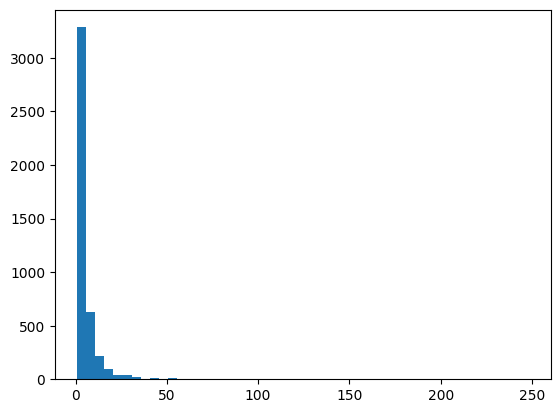

In [9]:
_ = plt.hist(invoice_per_costumer, bins=50)

In [10]:
# Primeira limpeza: Remover duplicidades
retail = retail[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [11]:
# Vamos organizar por meses
retail['InvoiceMonth'] = retail['InvoiceDate'].dt.to_period('M')

In [12]:
# Vamos pegar o primeiro mês de compra, a entrada do cliente
retail['Cohort'] = retail.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [13]:
retail.head()

,CustomerID,InvoiceNo,InvoiceDate,InvoiceMonth,Cohort
0,17850.0,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12,2010-12


In [14]:
retail_cohort = retail.groupby(['Cohort', 'InvoiceMonth']).agg(n_customers=('CustomerID', 'nunique')) \
    .reset_index(drop=False)
retail_cohort.head()

,Cohort,InvoiceMonth,n_customers
0,2010-12,2010-12,948
1,2010-12,2011-01,362
2,2010-12,2011-02,317
3,2010-12,2011-03,367
4,2010-12,2011-04,341


In [15]:
retail_cohort['Period'] = (retail_cohort.InvoiceMonth - retail_cohort.Cohort).apply(lambda x: x.n)
retail_cohort.head()

,Cohort,InvoiceMonth,n_customers,Period
0,2010-12,2010-12,948,0
1,2010-12,2011-01,362,1
2,2010-12,2011-02,317,2
3,2010-12,2011-03,367,3
4,2010-12,2011-04,341,4


In [16]:
cohort_pivot = retail_cohort.pivot_table(index='Cohort', columns='Period', values='n_customers')
cohort_pivot

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
cohort_size = cohort_pivot.iloc[:,0]
cohort_size

Cohort
2010-12    948.0
2011-01    421.0
2011-02    380.0
2011-03    440.0
2011-04    299.0
2011-05    279.0
2011-06    235.0
2011-07    191.0
2011-08    167.0
2011-09    298.0
2011-10    352.0
2011-11    321.0
2011-12     41.0
Freq: M, Name: 0, dtype: float64

In [18]:
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


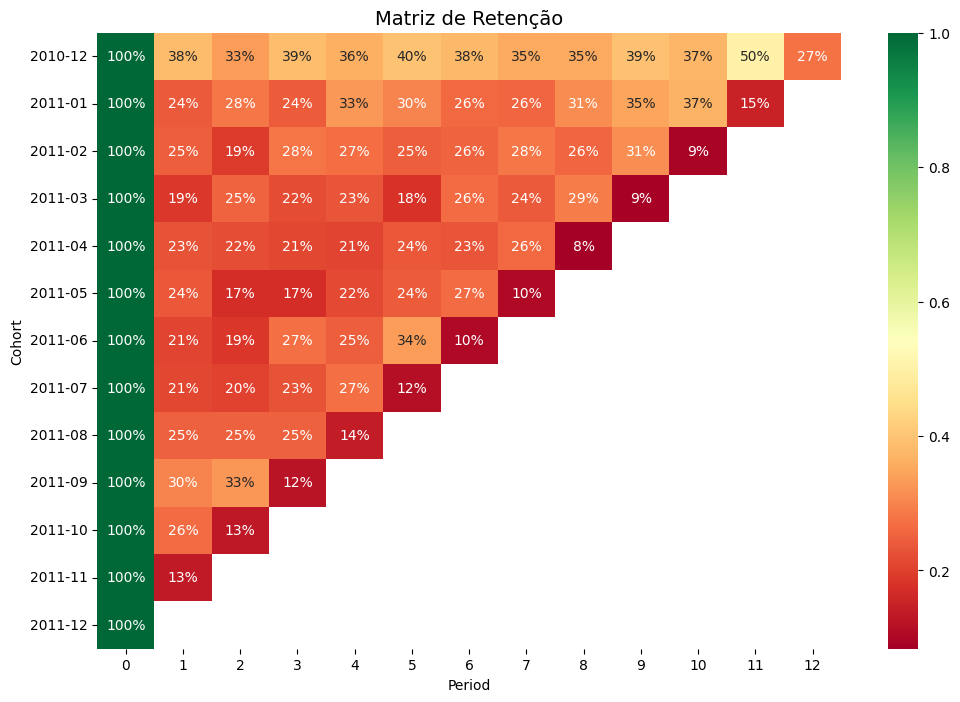

In [19]:
_ = plt.subplots(figsize=(12, 8))
_ = sns.heatmap(
    data = retention_matrix,
    mask = retention_matrix.isnull(),
    annot = True,
    fmt = '.0%',
    cmap = 'RdYlGn'
)

_ = plt.title('Matriz de Retenção', size=14)

Insights da Tabela de Análise de Cohort para Retenção de Clientes: 
- A retenção diminui consistentemente ao longo dos meses para todas as cohorts, o que é um comportamento esperado em muitos negócios. Isso reflete que a maioria dos clientes tende a se desligar com o tempo, a menos que haja ações para engajá-los.
- A cohort de Dezembro de 2010 apresenta boa retenção nos meses iniciais, especialmente até o 9º mês (39.45%).
- A cohort de Setembro de 2011 tem um desempenho superior no 2º e 3º mês, com taxas de 29.87% e 32.55%, respectivamente, sugerindo um possível impacto positivo de alguma ação de marketing ou melhoria no produto.
- As cohorts mais recentes, como Novembro de 2011 e Outubro de 2011, mostram taxas de retenção muito baixas. Isso pode indicar: dificuldades em manter clientes engajados; alterações na estratégia de aquisição que atraíram usuários com menor intenção de longo prazo.